[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xiao-Chen820/AI-Driven-trend-and-Pattern-analysis-tool/blob/main/Tutorials/CountMap.ipynb)

In [ ]:
import geopandas as gpd
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import folium
from folium.plugins import HeatMap
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import morecantile
import mercantile
from pyproj import Transformer
# from pyproj import Proj, transform
import time
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from osgeo import osr
from shapely import geometry, wkt
from shapely.ops import transform

# 1. Database Connection #

We have three ways to connect to PostgreSQL:


1. Using **psql** (a terminal-based front-end to PostgreSQL)

2. Using **Pgadmin 4** (a a graphical user interface administration tool to manage PostgreSQL)

3. Using **psycopg2** (a python package to connect to PostgreSQL).

We will use psycopg2 to set up the connection.




In [ ]:
def set_up_connection(db_host, port, user, pwd, db):
    try:
        connection = psycopg2.connect(
        host=db_host,
        port=port,
        user=user,
        password=pwd,
        database=db,
        )
        # cursor = connection.cursor()
        print('Connection established successfully!')
        return connection
    except Exception as e:
        print("Error connecting to the database:", e)

# 2. Data Query from the database #
## 2.1. Create a ROI before querying for centroids ##

By creating the BBOX, we can use it for querying data within a single tile. However, sometimes we might want to visualize the map in a single tile, but sometimes, we also want to draw a large Region of Interest (ROI) and map all the count maps of tiles in a batch processing.

In this section, we will introduce three ways to select tile(s) to map the count maps.

The following lines showing how to select **a single tile** as ROI, given a single point (a mouse location).

**tms.tile()** allows us to get a tile object by giving a specific coordinates.

In [ ]:
def lat_long_to_tile(lat, long, zoom_level):
    # Set default TileMatrixSets into Spherical Mercator  (EPGS:4326)
    tms = morecantile.tms.get("WGS1984Quad")
    # Get Tile X, Y, Z from lat and long
    Tile_XYZ = tms.tile(lng = long, lat = lat, zoom = zoom_level)
    print("Tile information:" + str(Tile_XYZ))
    return Tile_XYZ

## 2.2. Convert the tile to Bounding Box (BBOX) ##


Since we want to map count map at tile level, so once we get XYZ information of a tile, we will convert the tile into a BBOX which contains a latitude and longitude extent. The BBOX extent can be used for querying data that falls within it.


To convert to BBOX, we first need to know the bounds of this selected tile.

BBOX will return the min and max value of longitude, as well as min and max value of latitude.

After we got the min and max value of longitude, as well as min and max value of latitude, we can construct a rectangle consisting of four points in coordinate system (EPSG: 4326).
However, since the data in database is in another projection (EPSG: 3413), we will convert this rectangle into this projection. Under this projection, the rectangle may be convert to another polygon shape. In order to complete this conversion, we need to build up a polygon to store the original four points, and then transform the polygon into the projection (EPSG: 3413).
This will return a reprojected BBOX which can be used for querying data in database.

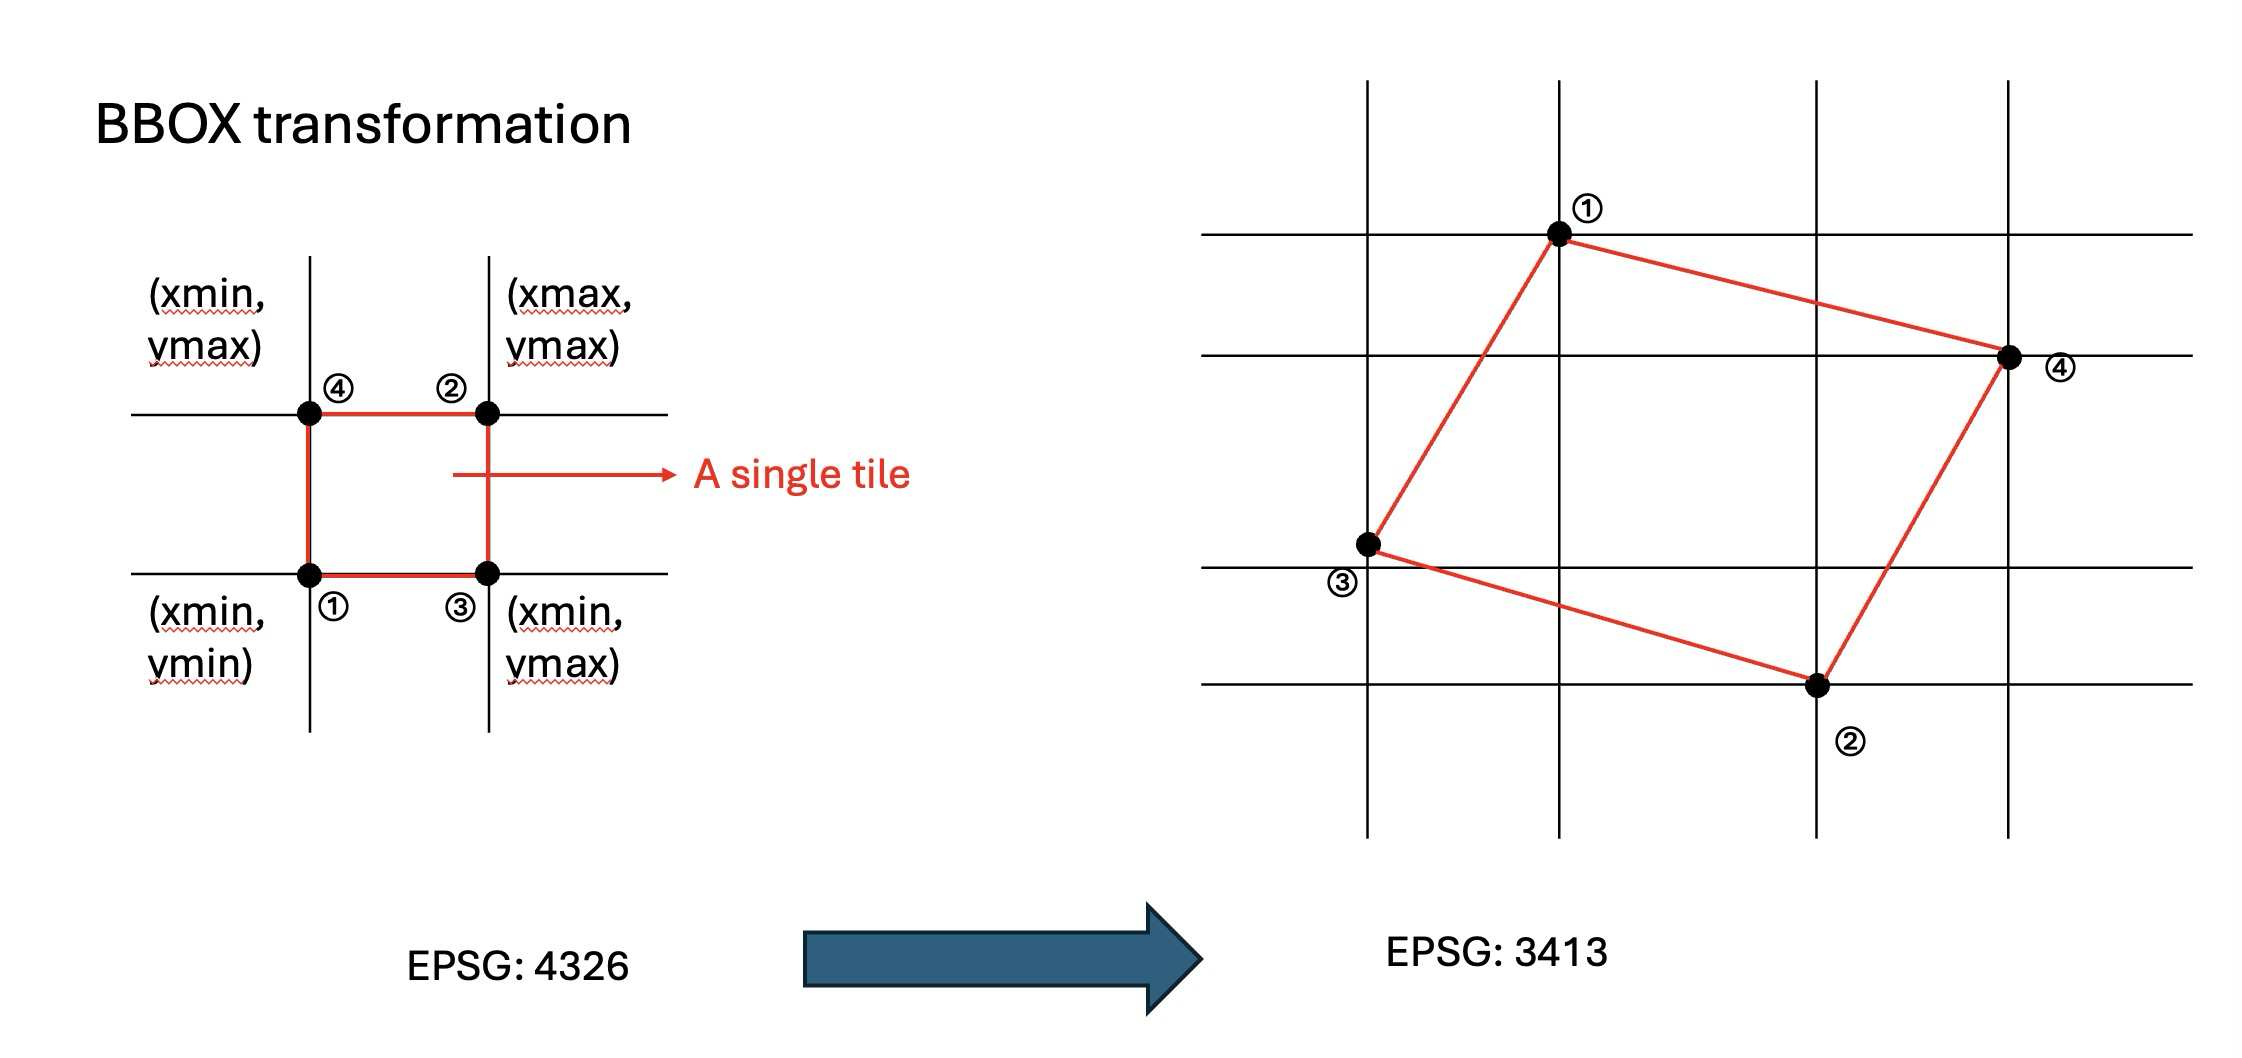


In [ ]:
def BBOX_transformation(x1, y1, x2, y2):
    # x1: xmin, y1: xmin, x2: xmax, y2: ymax
    p1 = geometry.Point(x1, y1)
    p2 = geometry.Point(x1, y2)
    p3 = geometry.Point(x2, y2)
    p4 = geometry.Point(x2, y1)
    pointList = [p1, p2, p3, p4]
    poly = geometry.Polygon([[p.x, p.y] for p in pointList])

    # If we want to transform BBOX into 3413 first, then perform the following code
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)
    reprojected_BBOX = transform(transformer.transform, poly)
    return str(reprojected_BBOX)

In [ ]:
def tile_to_BBOX(Tile_XYZ):
    tms = morecantile.tms.get("WGS1984Quad")
    bbox = tms.bounds(Tile_XYZ)
    # bbox[0]: long_xmin, bbox[1]: lat_ymin, bbox[2]: long_xmax, bbox[3]: lat_ymax
    return BBOX_transformation(bbox[0], bbox[1], bbox[2], bbox[3])

## 2.3. Query centroids within the BBOX ##
After creating a point-based geometry table, we can start query in the table. This is the most important step in this section.

We want to query all the centroids point falling within the tile (BBOX) to be queried and return specific rows (data) and columns (attributes) from database we want.

We may have to create a **buffer** for the BBOX: when creating tile-level count maps, the count maps within tiles which are always next to each other. **Border effect** is imposed by visualizing the border of regions (in our case, it is tiles). When mapping tile-level maps, border effect may present inconsistent rendering effects at the border between tiles due to missing the adjacent points (information) in other tiles. It is especially obvious issue in draw maps which need rendering effects based on around points, such as the smoothing effect in heatmaps. Considering the border effect, we will create a buffer to include points out of the tile extent to make up the information that a rendering effects will need. In other words, when we are trying to draw count map (or other maps, such as heatmaps), we will create a slightly larger buffer of a tile extent (e.g., 100 meters in our code), for querying all of the polygon centroids within a tile or a little outside of the tile.


**Geopandas** will be used to read shapefile from database after connection is built up successfully:

In [ ]:
def sql_to_geodataframe(query, conn):
   # crs: Coordinate reference system to use for the returned GeoDataFrame
   pd.set_option('display.max_colwidth', None)
   geo_df = gpd.read_postgis(query, conn, geom_col='geom_centroid', crs="3413")
   return geo_df

In [ ]:
def get_centroids_within_bbox(bbox, col_names, conn):
    # If we want to query data from database in 3413, perform this
    query = "SELECT " + col_names + " FROM alaska_all_3413 polygons WHERE ST_within(polygons.geom_centroid, ST_Buffer(ST_GeomFromText('" + bbox + "', 3413), 100))"

    # If we want to query data from database in 4326, perform this
    # query = "SELECT " + col_names + " FROM alaska_146_157_167_168_v2 polygons WHERE ST_within(ST_centroid(polygons.geom), ST_GeomFromText('" + bbox + "',4326))"
    # print("--------------------The query is:--------------------")
    print(query)
    start = time.time()
    geo_df = sql_to_geodataframe(query, conn)
    end = time.time()
    print(f"Data Extracted! The runtime of getting data from database is {end - start}")
    return geo_df

## 2.4. Get longitude and latitude data of each centroid point ##
we have got the geodataframe containing centroid points within the tile we used to query. (As shown in the sql_to_geodataframe function)

In this section, we will plot out a count map with these centroid points.

First of all, we need to extract **longitude** and **latitude** information from the geodataframe. These pairs of coordinates will be used for drawing count map.


The following lines showing how to select **a single tile** as ROI, given **a single point (a mouse location)**.

In [ ]:
def lat_long_to_BBOX(lat, long, zoom_level):
    Tile_XYZ = lat_long_to_tile(lat, long, zoom_level)
    return tile_to_BBOX(Tile_XYZ)

In [ ]:
def lat_long_to_geo_df(lat, long, zoom_level, col_names, conn):
    reprojected_bbox = lat_long_to_BBOX(lat, long, zoom_level)
    return get_centroids_within_bbox(reprojected_bbox, col_names, conn)

In [ ]:
def geo_df_to_heatmap_xy(geo_df):
    points = geo_df.copy()
    # change geometry
    points['geom_centroid'] = points['geom_centroid']
    # If database is in 3413, perfom the following code
    points['geom_centroid'] = points['geom_centroid'].to_crs(epsg=4326)
    # print(points)
    longs = [point.x for point in points.geom_centroid]
    lats = [point.y for point in points.geom_centroid]
    return longs, lats

# 3. Count map generation #

Before we draw the count map, we have to pay attention to the data extent and count map extent. There are two points we need to be careful:

1. If we use the longitude and latitude as x and y data and plot them directly in the count map, the plot extent would be various depending on the data extent. It is because, in some tiles (especially for tiles which are located at border of the continuous Ice Wedge Polygons areas), the data extent will be smaller than the predefined tile extent. If we just use data extent as count map extent, we will get various shape or size of count map. It is not what we desire since it is not plotted as the same size of a tile.

2. The buffer of BBOX we created to query for data, will enlarge the actual tile extent. If we directly use the data extent returned from database as a map extent, the map extent will not be equal to tile extent, which is not what we want.

Below is an example of heatmaps of different data extent.
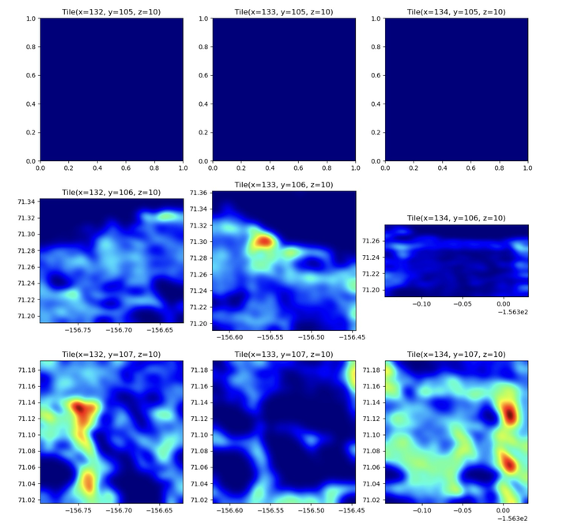

To solve these two issues, we will apply two strategies in according to the issues above:

1. making up 0 values to fill up no data areas, when the tiles are located at the continuous Ice Wedge Polygon areas. (Section 9.1.)

2. Clip the data returned from database into the tile extent after rendering, but before ploting out the count map. This will retain the rendering effect built based on adjacent points, and will also align the data extent with tile extent. (Section 9.2.)


## 3.1.	Fill 0 values to no data area. Reset data extent via bins ##
To do this, we can use the **np.arrange()** to create bins to divide the entire extent along with the x-axis and y-axis. The bin count can be further used to create an array used for 2-D histogram in create a count map.

In [ ]:
def extent_adjustment(tile):
    tms = morecantile.tms.get("WGS1984Quad")
    tile_extent = [tms.xy_bounds(tile)[0], tms.xy_bounds(tile)[2], tms.xy_bounds(tile)[1], tms.xy_bounds(tile)[3]]
    print("Tile extent:")
    print(tile_extent[0], tile_extent[1], tile_extent[2], tile_extent[3])
    # bin_x = np.arange(tile_extent[0], tile_extent[1], 0.0001)
    # bin_y = np.arange(tile_extent[2], tile_extent[3], 0.0001)
    # return [bin_x, bin_y]
    return tile_extent

The above function is similar to tile_to_BBOX() function we created

After we get tile extent, we will consider two situations and perform them in if else condition:
1. When a large ROI contains a tile without any data located we will fill in 0 values to the entire tile. When there is no any point within the tiles, the longitude and latitude will return null values. In this case, we will get tile extent and set it as the array range we will create based on. Since one single tile consists of 256 * 256 pixels as mentioned in section 6.1., we will set 1/256 (0.00390625) as a step, starting from the min of latitude and longitude to the max of latitude and longitude.

2. The data extent can entirely or partially fill into the tile extent, we will have to set 0 values in these empty areas if data extent cannot fully cover the tile extent.


In [ ]:
def get_data_extent(longs, lats, tile_extent):
    if not longs or not lats:
        # Each tile has 256 pixels, and each pixel is 0.00390625 in bin width and height
        bin_x = np.arange(tile_extent[0], tile_extent[1], 0.00390625)
        bin_y = np.arange(tile_extent[2], tile_extent[3], 0.00390625)
    else:
        min_long = min(longs)
        max_long = max(longs)
        min_lat = min(lats)
        max_lat = max(lats)
        data_extent = [min_long, max_long, min_lat, max_lat]
        # To make sure 0 value can fill into the no data region
        bin_x = np.arange(min(tile_extent[0], data_extent[0]), max(tile_extent[1], data_extent[1]), 0.00390625)
        bin_y = np.arange(min(tile_extent[2], data_extent[2]), max(tile_extent[3], data_extent[3]), 0.00390625)
    return [bin_x, bin_y]

## 3.2. Create count map within a single tile ##

After we get the array from the above function, we will use the bins to create count map with the help of **np.histogram2d().**

In [ ]:
def create_heatmap(longs, lats, tile, data_bins, extent):
    heatmap, xedges, yedges = np.histogram2d(longs, lats, bins=data_bins, density=False)
    # heatmap = gaussian_filter(heatmap, sigma=32, radius=20)
    data_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Clip the heatmap based on the tile extent
    heatmap_clipped, xedges_clipped, yedges_clipped = clip_heatmap(heatmap, extent, xedges, yedges)
    data_extent_clipped = [xedges_clipped[0], xedges_clipped[-1], yedges_clipped[0], yedges_clipped[-1]]

    print("Heatmap extent:")
    print(data_extent[0], data_extent[1], data_extent[2], data_extent[3])
    print("Clipped heatmap extent:")
    print(data_extent_clipped[0], data_extent_clipped[1], data_extent_clipped[2], data_extent_clipped[3])
    return heatmap_clipped.T, tile

## 3.3.	Fit the data extent to count map extent ##

In the above function, you may notice the clip_heatmap() function. This is created to fit the larger data extent returned from the database due to the buffer.

In [ ]:
def clip_heatmap(heatmap, extent, xedges, yedges):
    xmin, xmax, ymin, ymax = extent
    x_indices = np.where((xedges >= xmin) & (xedges <= xmax))[0]
    y_indices = np.where((yedges >= ymin) & (yedges <= ymax))[0]

    # Ensure that the indices don't exceed the size of the histogram
    x_indices = np.clip(x_indices, 0, heatmap.shape[1])
    y_indices = np.clip(y_indices, 0, heatmap.shape[0])

    xedges_clipped = xedges[x_indices[0]:x_indices[-1] + 1]
    yedges_clipped = yedges[y_indices[0]:y_indices[-1] + 1]

    clipped_heatmap = heatmap[y_indices[0]:y_indices[-1], x_indices[0]:x_indices[-1]]
    return clipped_heatmap, xedges_clipped, yedges_clipped

This function can return a clipped count map that fit in the tile extent.

## 3.4. Plot count map within a single tile ##

Since we want to set the color scale for rendering the count map, from 0 to the overall maximum value among the entire tile(s) within our ROI.

To get the overall max value, we will use the **np.max()** to get the biggest value among the input array. In the meanwhile, we can plot our the histogram to check the distribution of count values.


In [ ]:
def statistics_histogram(array):
    # Calculate the overall statistics for all heatmaps
    overall_min = np.min(array)
    overall_max = np.max(array)
    overall_mean = np.mean(array)
    overall_std = np.std(array)

    # Print the overall statistics
    print("Overall Min:", overall_min)
    print("Overall Max:", overall_max)
    print("Overall Mean:", overall_mean)
    print("Overall Standard Deviation:", overall_std)

    # Plot histogram
    plt.hist(array, bins=100)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Combined Array')
    plt.savefig("/home/xchen/code/shpMapping/histogram/Tiles_LargerROI.png")
    # plt.savefig("/home/xchen/code/shpMapping/histogram/9Tiles_" + str(tile) + ".png")

    return overall_max

In [ ]:
def plot_tile(tile, col_names, conn):
    bbox = tile_to_BBOX(tile)
    geo_df = get_centroids_within_bbox(bbox, col_names, conn)
    longs, lats = geo_df_to_heatmap_xy(geo_df)
    tile_extent = extent_adjustment(tile)
    data_bins = get_data_extent(longs, lats, tile_extent)
    data, tile_name = create_heatmap(longs, lats, tile, data_bins, tile_extent)
    print(data, tile_extent)

    # Concatenate all arrays from the list into one single array
    combined_array = np.concatenate(data, axis=None)
    print(combined_array)
    max_value = statistics_histogram(combined_array)
    print(f"The maximum value is: {max_value}")
    print(data, tile_extent)

    plt.figure(figsize=(10, 10))
    plt.imshow(data, extent=tile_extent, origin='lower', cmap=cm.jet, vmin=0, vmax=max_value)
    plt.title("Heatmap: " + str(tile_name))
    plt.xlim(tile_extent[0], tile_extent[1])
    plt.ylim(tile_extent[2], tile_extent[3])
    plt.savefig("/home/xchen/code/shpMapping/heatmap_output/"  + str(tile_name) + ".png")
    return 0

## 3.5. Check the border effect by mapping out 9 count maps ##

Here we introduce two way to map out the 9 adjacent tiles to check the border effect.

1. Map 9 tiles, given the central tile object.

2. Map 9 tiles, given the mouse location.

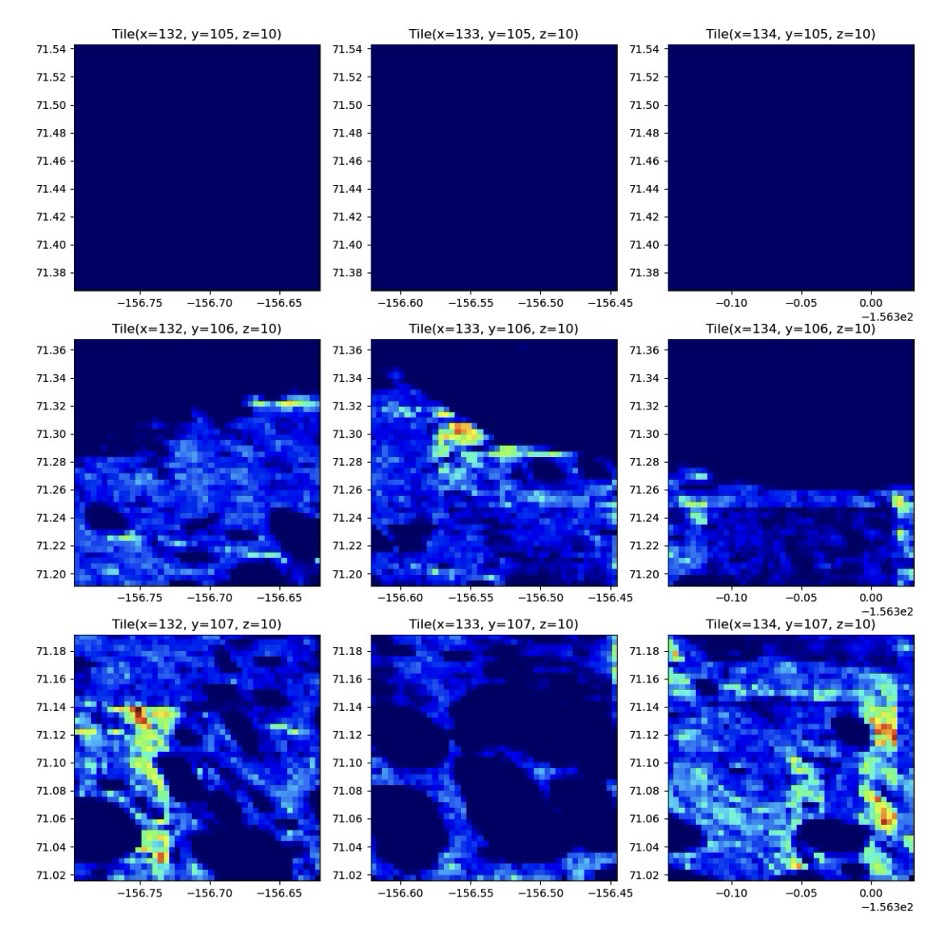


In [ ]:
def center_tile_to_9_tiles(tile, col_names, center_tile_name, conn):
    tms = morecantile.tms.get("WGS1984Quad")
    data_list = []
    tile_extent_list = []
    tile_name_list = []

    for i in range(-1, 2):
        for j in range(-1, 2):
            t = morecantile.Tile(x=tile.x + j, y=tile.y + i, z=tile.z)
            b = tile_to_BBOX(t)
            geo_df = get_centroids_within_bbox(b, col_names, conn)
            longs, lats = geo_df_to_heatmap_xy(geo_df)
            tile_extent = extent_adjustment(t)
            # To get the data extent after buffering
            data_bins = get_data_extent(longs, lats, tile_extent)
            img, tile_name = create_heatmap(longs, lats, t, data_bins, tile_extent)
            data_list.append(img)
            tile_extent_list.append(tile_extent)
            tile_name_list.append(tile_name)

    # Concatenate all arrays from the list into one single array
    combined_array = np.concatenate(data_list, axis=None)
    print(combined_array)

    max_value = statistics_histogram(combined_array)
    print(f"The maximum value is: {max_value}")

    fig, axs = plt.subplots(3, 3, figsize=(14, 14))

    for ax, data, extent, tilename in zip(axs.flatten(), data_list, tile_extent_list, tile_name_list):
        print(data, extent)
        ax.imshow(data, extent=extent, origin='lower', cmap=cm.jet, vmin=0, vmax=max_value)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_title(tilename)

    plt.savefig("/home/xchen/code/shpMapping/heatmap_output/" + "Tiles_s32r20_buffer100_" + center_tile_name + "_v5.png")
    return 0

In [ ]:
def mouse_to_9_tiles(lat, long, zoom_level, col_names, conn):
    tile_center = lat_long_to_tile(lat, long, zoom_level)
    print(tile_center)
    print(type(tile_center))
    return center_tile_to_9_tiles(tile_center, col_names, str(tile_center), conn)

## 3.6. Plot all of the count map of tiles that falls within a user-defined ROI ##

In [ ]:
def plot_heatmap(img, tile_extent, tile, max_value):
    print("Plotting heatmap...")
    plt.figure(figsize=(10, 10))
    plt.imshow(img, extent=tile_extent, origin='lower', cmap=cm.jet, vmin=0, vmax=max_value)
    plt.title("Heatmap: " + str(tile))
    plt.xlim(tile_extent[0], tile_extent[1])
    plt.ylim(tile_extent[2], tile_extent[3])
    plt.savefig("/home/xchen/code/shpMapping/heatmap_output/" + str(tile) + ".png")
    plt.close()

In [ ]:
def plot_all_tiles_within_ROI(ROI_xmin, ROI_xmax, ROI_ymin, ROI_ymax, zoom_level, col_names, conn):
    # Get all tiles within bbox
    tms = morecantile.tms.get("WGS1984Quad")
    # Print tiles that overlap or contain a lng/lat point, bounding box, or GeoJSON objects.
    tiles = tms.tiles(ROI_xmin, ROI_ymin, ROI_xmax, ROI_ymax, zoom_level)
    tiles_list = list(tiles)
    print(tiles_list)
    print(f"The number of tiles within the geographic bbox is: {len(tiles_list)}")
    data_list = []
    tile_extent_list = []
    tile_name_list = []

    for tile in tiles_list:
        # Get all points within the tile
        bbox = tile_to_BBOX(tile)
        geo_df = get_centroids_within_bbox(bbox, col_names, conn)
        longs, lats = geo_df_to_heatmap_xy(geo_df)

        # Smoothing each plot
        tile_extent = extent_adjustment(tile)
        data_bins = get_data_extent(longs, lats, tile_extent)
        data, tile_name = create_heatmap(longs, lats, tile, data_bins, tile_extent)
        data_list.append(data)
        tile_extent_list.append(tile_extent)
        tile_name_list.append(tile_name)

    max_value = statistics_histogram(np.concatenate(data_list, axis=None))

    # Plot all heatmaps after getting the maximum value
    for data, tilename, tile_extent in zip(data_list, tile_name_list, tile_extent_list):
        plot_heatmap(data, tile_extent, tilename, max_value)

    return 0

In [ ]:
if __name__=="__main__":
    hostname = "cici.lab.asu.edu"
    port = "5432"
    user = "postgres"
    password = "shirly"
    database = "postgres"

    column = ["gid", "class", "sensor", "date", "time", "image", "area", "centroidx", "centroidy", "permeter", "length", "width", "geom_centroid"]
    column_names = "centroidx, centroidy, geom_centroid"

    mouse_lat = 71.31610
    mouse_long = -156.60027

    # Small ROI
    # west = -156.47441
    # south = 70.40887
    # east = -153.92505
    # north = 70.87147

    # Large ROI
    # west = -166.43910
    # south = 69.09646
    # east = -141.05628
    # north = 70.95322

    zoom_level = 10
    # heatmap_name = "zoomlevel" + str(zoom_level) + "newPoint4"

    connection = set_up_connection(hostname, port, user, password, database)

    # Plot one single tile
    # tms = morecantile.tms.get("WGS1984Quad")
    # tile = morecantile.Tile(x=134, y=106, z=10)
    # plot_tile(tile, column_names, connection)

    # Plot from mouse location to heatmap using matplotlib or folium
    # lat_long_query_result = lat_long_to_geo_df(mouse_lat, mouse_long, zoom_level, column_names, connection)
    # plot_heatmap(lat_long_query_result, heatmap_name)

    # Plot from ROI to heatmaps using matplotlib
    # plot_all_tiles_within_ROI(west, east, south, north, zoom_level, column_names, connection)

    # Plot 9 tiles based on the central tile to check the border effect
    tms = morecantile.tms.get("WGS1984Quad")
    tile = morecantile.Tile(133, 106, 10)
    tile_name = str(tile)
    center_tile_to_9_tiles(tile, column_names, tile_name, connection)

    # Plot 9 tiles based on the mouse location to check the border effect
    # mouse_to_9_tiles(mouse_lat, mouse_long, zoom_level, column_names, connection)